# Raman intensities visualization

This notebook aims at visualizing and analysing the Raman intensities computed with BigDFT. One part consists in the comparison of the BigDFT results with the experimental and theoretical values reported in the literature. Another part focuses on defining error-bars on the Raman intensities coming from BigDFT. This can be done thanks to the derivation of specific parameters for each molecule, that define when a computation can be considered as converged. This will help us in defining an error-bar on the Raman instensity when the total energy is converged up to a precision per atom of 2 meV.

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Turn-on all warnings from numpy into errors
np.seterr(all="raise")

# Connect to the database and define a cursor
conn = sqlite3.connect('../results.db')
c = conn.cursor()

In [2]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

In [3]:
# Get all the relevant data
MOLECULES = [name for (name,) in c.execute("""SELECT name FROM molecule""").fetchall()]
HGRIDS = [value for (value,) in c.execute("""SELECT value FROM hgrid""").fetchall()][::-1]
RMULTS = c.execute("""SELECT frmult, crmult FROM rmult""").fetchall()
nb_notebooks = c.execute("SELECT COUNT(*) FROM notebook").fetchall()[0][0]
xmax = nb_notebooks // len(MOLECULES)

In [4]:
# Be sure to run the post_processing.ipynb notebook to make sure the
# converged_param table is in the database.
data = c.execute("""SELECT * FROM converged_param""").fetchall()
CONVERGED_PARAMS = {
    name: {"hgrids": hg, "rmult": [frm, crm]}
    for (name, hg, frm, crm) in data
}
# Looking at the convergence data, one suspects that the correct
# values for hgrids should be 0.38 for the CH4 molecule
CONVERGED_PARAMS["CH4"]["hgrids"] = 0.38

## Raman intensities convergence for each molecule

We first add a temporary table to the database, so as to more easily reason about the Raman intensities found with BigDFT.

In [5]:
try:
    # Put all the relevant BigDFT data in a single temprary table
    c.execute("CREATE TEMP TABLE intensities AS "
              "SELECT n.id, ph.value AS phonon_energy, r.value AS raman_intensity, n.molecule, n.hgrid, n.crmult, n.frmult "
              "FROM Raman_intensity r "
              "JOIN phonon_energy ph ON ph.id_mode = r.id_mode AND ph.id_notebook = r.id_notebook "
              "JOIN notebook n ON n.id = ph.id_notebook "
              "WHERE ph.value > 200")
except sqlite3.OperationalError as e:
    print(repr(e))

We then define two functions:
- one to plot the value of the Raman intensities for a given set of phonons for a given molecule (*i.e*, those within a given energy window). The plotted data comes from the whole set of BigDFT input parameters available.
- the other is used to define the mean value and the standard deviation of the Raman intensity. It allows to separate the values coming from converged calculations from those coming from non-converged calculations.

In [6]:
def plot_Raman_intensities(
        name, e_lim, only_converged=False,
        show_experimental=False, show_theoretical=False,
        save_file=None,
):
    """
    Plot the Raman intensities of a given molecule. You can
    specifically filter the Raman intensities of specific phonons
    by giving an energy window and/or by selecting those coming
    from converged calculations ("converged" in the sense that the
    input parameters used to get these optimized positions were
    such that the precision per atom on the total energy of the
    system is below the desired value of 1 meV). The default is to
    use all the values, whether they can be considered as converged
    or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    e_lim : tuple of length 2
        Minimal and maximal energy of the normal modes to be
        considered.
    only_converged : bool
        If `True`, then only the Raman intensities coming from
        converged calculations are plotted.
    """
    # Set the plot
    plt.figure(figsize=(6,4.5))
    # Set the value of the converged parameters
    if only_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
        suffix = " (only converged)"
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
        suffix = ""
    if show_experimental:
        # Gather experimental values and plot them as lines
        exp = c.execute(
            "SELECT value, notes from exp_Raman_intensity "
            "WHERE molecule = ? "
            "      AND value >= ? AND value <= ?", [name, *e_lim]
        ).fetchall()
        exp_values  = [data[0] for data in exp]
        plt.hlines(exp_values, -1, xmax, label="Experimental", colors="k")
    if show_theoretical:
        # Gather theoretical values and plot them as lines
        th = c.execute(
            "SELECT value, notes from th_Raman_intensity "
            "WHERE molecule = ? "
            "      AND value >= ? AND value <= ?", [name, *e_lim]
        ).fetchall()
        th_values  = [data[0] for data in th]
        plt.hlines(th_values, -1, xmax, label="Theoretical", colors="b", linestyles="dotted")
    # Loop over the RMULTS to gather the Raman intensities
    for i, (frm, crm) in enumerate(RMULTS):
        if frm >= frm_min and crm >= crm_min:
            if "F" in name:
                # Filter out the larger hgrids
                c.execute(
                    "SELECT id, SUM(raman_intensity) "
                    "FROM intensities "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND phonon_energy >= ? AND phonon_energy <= ? AND hgrid <= 0.35 "
                    "      AND hgrid <= ? "
                    "GROUP BY id ",
                    (name, crm, frm, *e_lim, hg_max)
                )
            else:
                c.execute(
                    "SELECT id, SUM(raman_intensity) "
                    "FROM intensities "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND phonon_energy >= ? AND phonon_energy <= ? AND hgrid <= ? "
                    "GROUP BY id ",
                    (name, crm, frm, *e_lim, hg_max)
                )
        results = c.fetchall()
        x = [(id_nb - 1) // len(MOLECULES) for (id_nb, _) in results]
        intensity = [intensity for (_, intensity) in results]
        label = f"Grid extension = [{frm}, {crm}]"
        plt.scatter(x, intensity, label=label, c=colors[i%len(RMULTS)])
    # Plot vertical lines
    locs = [x * len(RMULTS) + len(RMULTS) - 0.5 for x in range(len(HGRIDS)-1)]
    ylim = plt.ylim()
    plt.vlines(locs, *ylim, linewidth=1)
    # Set x RMULTS
    locs = [x * len(RMULTS) + len(RMULTS) / 2 -0.5 for x in range(len(HGRIDS))]
    labels = [hg for hg in HGRIDS]
    plt.xticks(locs, labels)
    # Finalize plot
    plt.xlabel("Grid step")
    plt.ylabel(r"Raman intensity [$\AA^4$ amu$^{-1}$]")
    plt.xlim(-1, xmax)
    plt.title(name+suffix)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    if save_file:
        plt.savefig(save_file, bbox_inches="tight")
    plt.show()

In [7]:
def intensities_stats(name, e_lim, only_converged=False,
                  only_not_converged=False, verbosity=True):
    """
    Find the mean value and the standard deviation of a specific
    Raman intensity for a given molecule. You must specifically
    filter the Raman intensities coming from converged or not
    converged geometries ("converged" in the sense that the input
    parameters used to get these optimized positions were such that
    the precision per atom on the total energy of the system is
    below the desired value of 2 meV). The default is to use all
    the values, whether they can be considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    e_lim : tuple of length 2
        Minimal and maximal energy of the intensity to be considered.
    only_converged : bool
        If `True`, then only the Raman intensities coming from
        converged calculations are used to define the stats.
    only_not_converged : bool
        If `True`, then only the Raman intensities coming from 
        non-converged calculations are used to define the stats.
    """
    # Set the value of the converged parameters
    if only_converged or only_not_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
    # Gather the Raman intensities
    intensities = []
    if only_not_converged:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT SUM(raman_intensity) "
                "FROM intensities "
                "WHERE molecule = ? "  # intensities from the desired molecule
                "      AND phonon_energy >= ? AND phonon_energy <= ? "  # intensities related to phonons within the energy window
                "      AND hgrid <= 0.35 "  # hgrid not too large when F atom(s) in the molecule
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?) "
                "GROUP BY id",  # intensities coming from non-converged notebooks
                (name, *e_lim, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT SUM(raman_intensity) "
                "FROM intensities "
                "WHERE molecule = ? "
                "      AND phonon_energy >= ? AND phonon_energy <= ? "
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?) "
                "GROUP BY id",
                (name, *e_lim, hg_max, frm_min, crm_min)
            )
    else:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT SUM(raman_intensity) "
                "FROM intensities "
                "WHERE molecule = ? "
                "      AND phonon_energy >= ? AND phonon_energy <= ? "
                "      AND hgrid <= 0.35 "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ? "
                "GROUP BY id",  # intensities coming from all or converged notebooks
                (name, *e_lim, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT SUM(raman_intensity) "
                "FROM intensities "
                "WHERE molecule = ? "
                "      AND phonon_energy >= ? AND phonon_energy <= ? "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ? "
                "GROUP BY id",
                (name, *e_lim, hg_max, frm_min, crm_min)
            )
    intensities += [intensity for (intensity,) in c.fetchall()]
    try:
        mean = np.mean(intensities)
        std_dev = np.std(intensities)
        results = f"mean = {mean:1.7f} A^4.amu^-1; std. dev. = {std_dev:.2e} A^4.amu^-1; std. dev / mean = {std_dev / mean:.3e}"
        if verbosity:
            print(results)
    except (FloatingPointError, RuntimeWarning):
        mean = None
        std_dev = None
        if verbosity:
            print("Cannot compute quantites")
    return mean, std_dev

### CH4

Each subsection below is meant to focus on the study of one molecule. Here, we start with the CH$_4$ molecule. What is mainly checked here is the convergence of each Raman intensity with respect to the input parameters of BigDFT. Two figures are plotted: one with all the data point, the other with only the values coming from the converged calculations (*i.e.*, those with the good enough input parameters so that the precision on the total energies (which are used to conpute the intensities) are below 1 meV per atom, that is ~ 8 cm$^{-1}$).

We also compute the mean value and the standard deviation of the energy of each intensity, depending on the fact that the values are supposed to be converged or not converged (within our required precision).

As seen in the phonon energies visualization, it may not be easy to tell apart two modes when the results are not converged (this happens twice in our test set) so that the mean value and standard deviation cannot be derived in those cases.

CH$_4$ is another particular case, given that all the results are supposed to be converged, so that it is not possible to define a mean value for the not-converged intensities. However, the computations with `hgrids` = 0.4 may not be considered as converged (see the convergence study of CH4 with respect to `hgrids`: the precision for that particular point may be artificially too low). This is why the converged parameters of the CH4 may be updated in the beginning of this notebook, so as to account for that probable artifact.

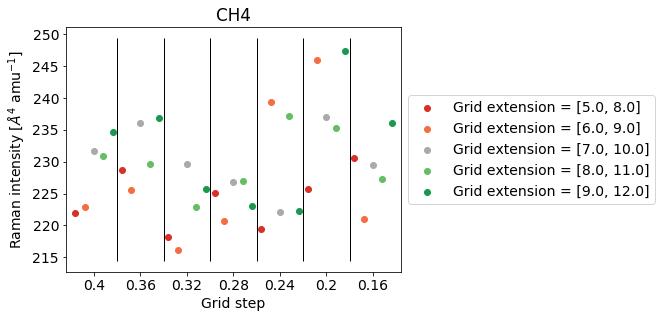

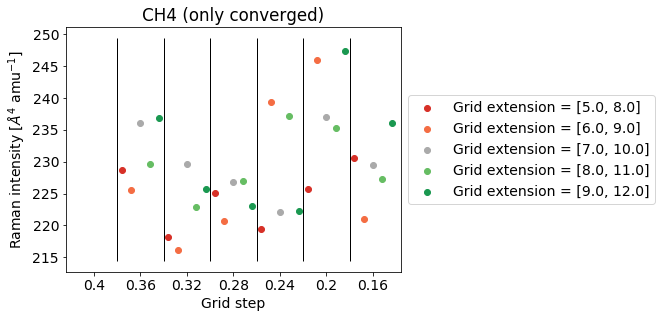

mean = 228.9381957 A^4.amu^-1; std. dev. = 7.75e+00 A^4.amu^-1; std. dev / mean = 3.385e-02
mean = 228.4274500 A^4.amu^-1; std. dev. = 5.10e+00 A^4.amu^-1; std. dev / mean = 2.231e-02


(228.42745, 5.09673116492401)

In [8]:
name = "CH4"
e_lim = (2930, 2975)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2943, 2949), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)  # use only supposedly converged intensities
intensities_stats(name, e_lim, only_not_converged=True)  # use only supposedly not converged intensities

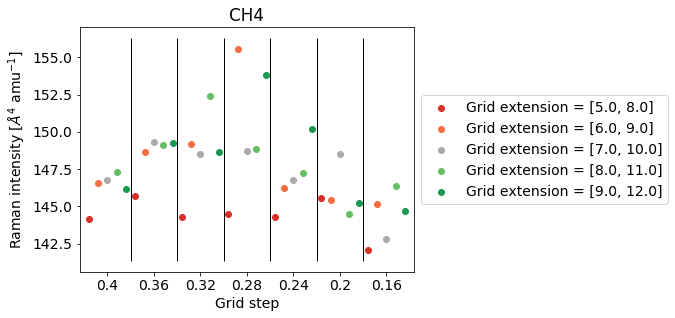

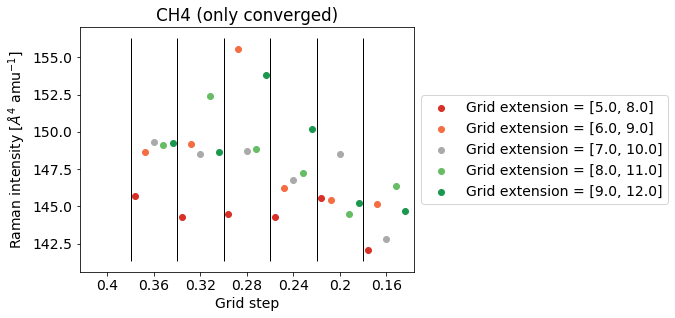

mean = 147.3948067 A^4.amu^-1; std. dev. = 3.05e+00 A^4.amu^-1; std. dev / mean = 2.069e-02
mean = 146.1918570 A^4.amu^-1; std. dev. = 1.07e+00 A^4.amu^-1; std. dev / mean = 7.341e-03


(146.19185702, 1.0732374434049206)

In [9]:
name = "CH4"
e_lim = (3075, 3100)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3078.5, 3081.1), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

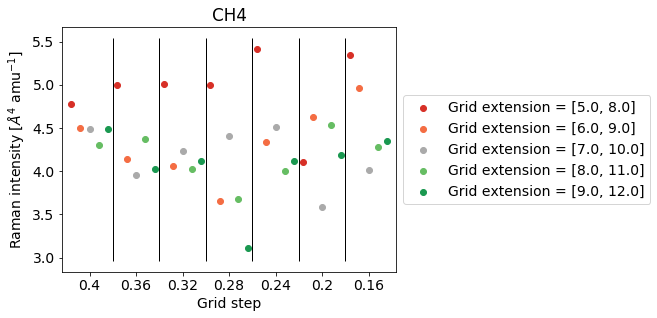

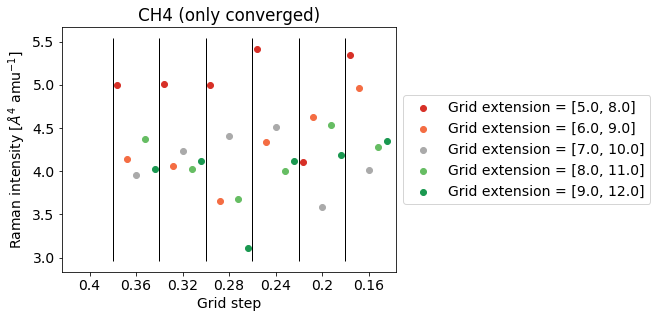

mean = 4.3051019 A^4.amu^-1; std. dev. = 5.11e-01 A^4.amu^-1; std. dev / mean = 1.186e-01
mean = 4.5116847 A^4.amu^-1; std. dev. = 1.51e-01 A^4.amu^-1; std. dev / mean = 3.357e-02


(4.511684732, 0.1514650160465726)

In [10]:
name = "CH4"
e_lim = (1470, 1525)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1470, 1480), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

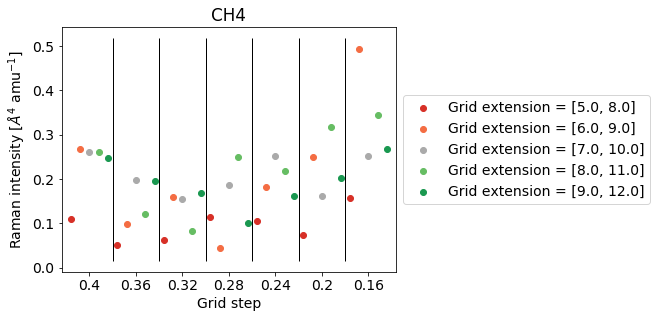

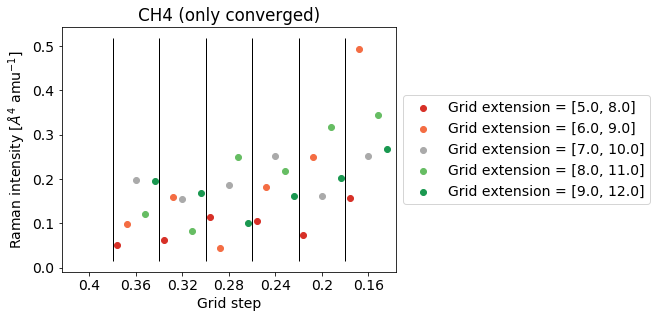

mean = 0.1809293 A^4.amu^-1; std. dev. = 9.54e-02 A^4.amu^-1; std. dev / mean = 5.272e-01
mean = 0.2292234 A^4.amu^-1; std. dev. = 6.04e-02 A^4.amu^-1; std. dev / mean = 2.633e-01


(0.2292234236, 0.06035885045408507)

In [11]:
name = "CH4"
e_lim = (1248, 1290)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1248, 1290), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### SiF4

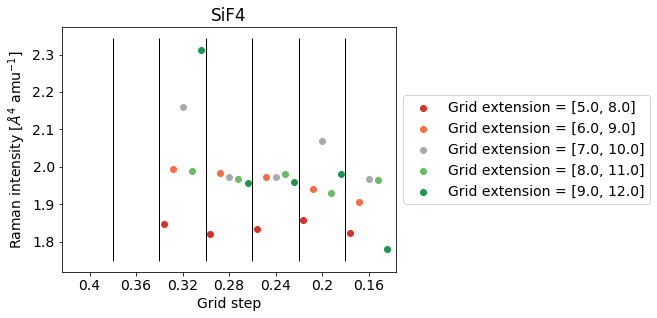

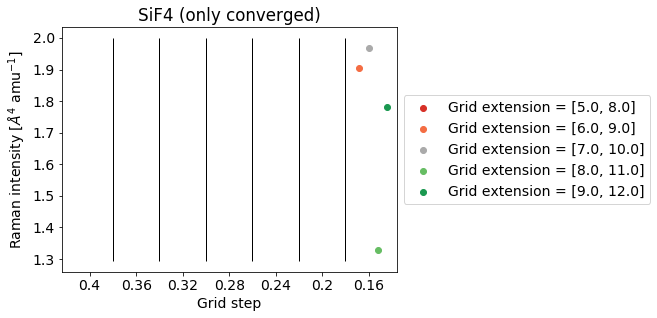

mean = 1.9046450 A^4.amu^-1; std. dev. = 7.54e-02 A^4.amu^-1; std. dev / mean = 3.961e-02
mean = 1.9676890 A^4.amu^-1; std. dev. = 1.10e-01 A^4.amu^-1; std. dev / mean = 5.612e-02


(1.9676890274761907, 0.11042282262609504)

In [12]:
name = "SiF4"
e_lim = (1000, 1070)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1009, 1011), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

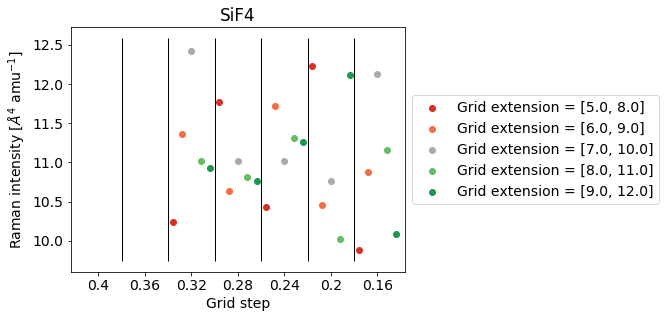

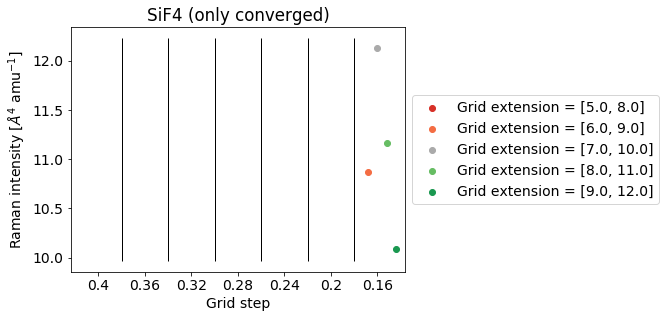

mean = 11.0627158 A^4.amu^-1; std. dev. = 7.29e-01 A^4.amu^-1; std. dev / mean = 6.593e-02
mean = 11.0562373 A^4.amu^-1; std. dev. = 6.84e-01 A^4.amu^-1; std. dev / mean = 6.191e-02


(11.056237307619048, 0.684487325133294)

In [13]:
name = "SiF4"
e_lim = (760, 860)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(773.5, 777), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

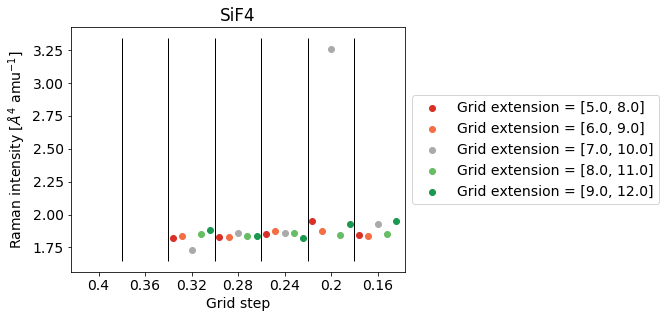

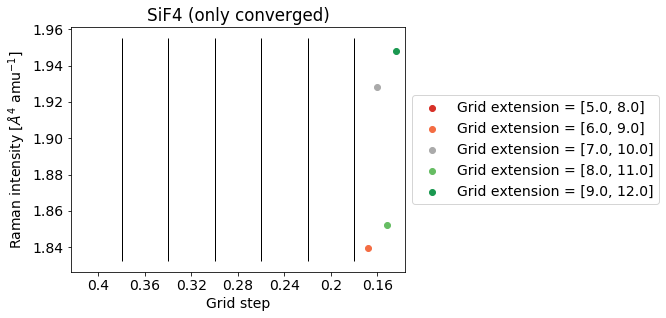

mean = 0.6343020 A^4.amu^-1; std. dev. = 3.72e-02 A^4.amu^-1; std. dev / mean = 5.870e-02
mean = 1.2578143 A^4.amu^-1; std. dev. = 3.27e-02 A^4.amu^-1; std. dev / mean = 2.603e-02


(1.2578142570000002, 0.032737675641719956)

In [14]:
name = "SiF4"
e_lim = (280, 560)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(280, 400), only_converged=True)
intensities_stats(name, (280, 300), only_converged=True)
# intensities_stats(name, (280, 300), only_not_converged=True)  # can't do that: too much noise on data to split intensities
intensities_stats(name, (300, 400), only_converged=True)
# intensities_stats(name, (300, 400), only_not_converged=True)  # can't do that: too much noise on data to split intensities

### H2O

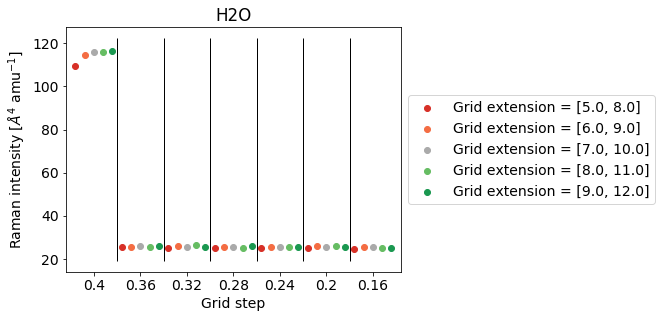

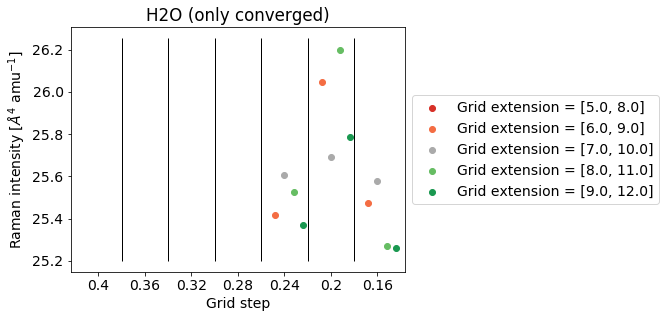

mean = 25.6025134 A^4.amu^-1; std. dev. = 2.79e-01 A^4.amu^-1; std. dev / mean = 1.088e-02
mean = 44.8570494 A^4.amu^-1; std. dev. = 3.67e+01 A^4.amu^-1; std. dev / mean = 8.184e-01


(44.85704935217392, 36.710546031572676)

In [15]:
name = "H2O"
e_lim = (3745, 3880)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3814, 3821), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

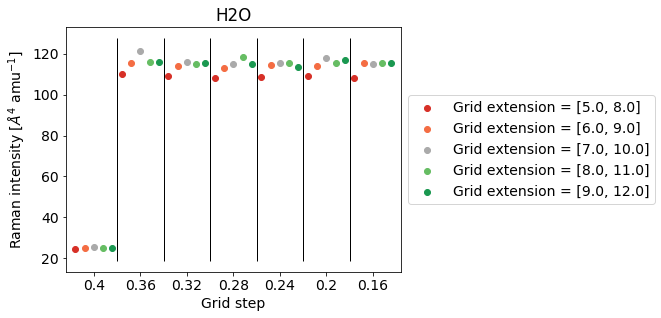

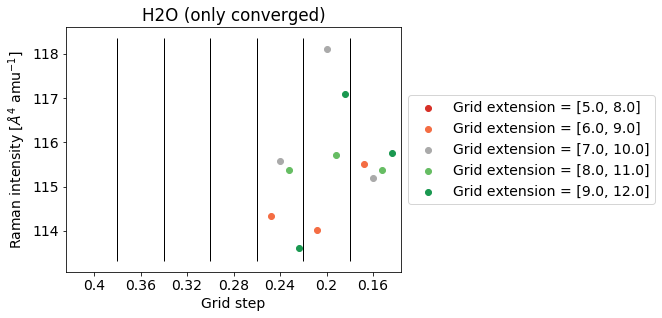

mean = 115.4709578 A^4.amu^-1; std. dev. = 1.18e+00 A^4.amu^-1; std. dev / mean = 1.022e-02
mean = 94.3388540 A^4.amu^-1; std. dev. = 3.67e+01 A^4.amu^-1; std. dev / mean = 3.887e-01


(94.33885404347826, 36.671417794693944)

In [16]:
name = "H2O"
e_lim = (3695, 3740)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3698, 3705), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

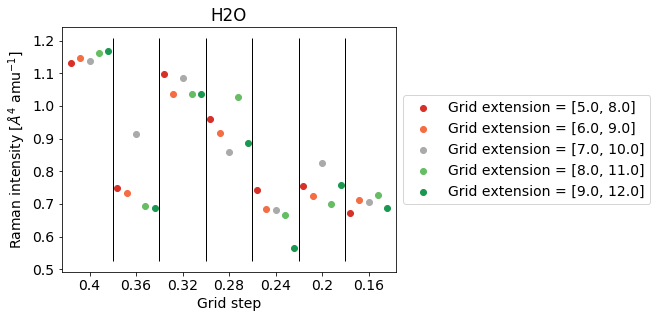

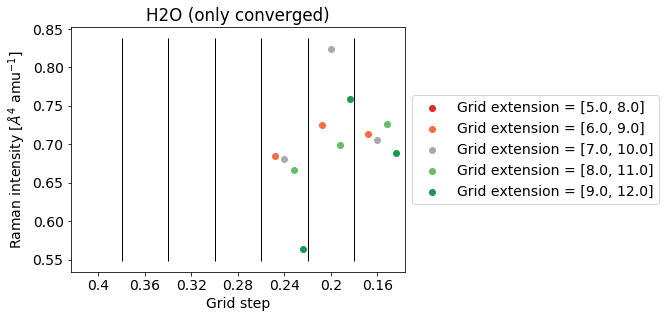

mean = 0.7030772 A^4.amu^-1; std. dev. = 5.82e-02 A^4.amu^-1; std. dev / mean = 8.274e-02
mean = 0.9407531 A^4.amu^-1; std. dev. = 1.70e-01 A^4.amu^-1; std. dev / mean = 1.804e-01


(0.9407531047391305, 0.1696663508865761)

In [17]:
name = "H2O"
e_lim = (1515, 1725)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1523, 1557), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### HCCH

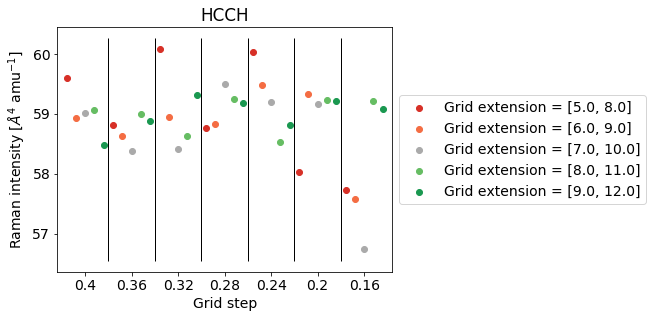

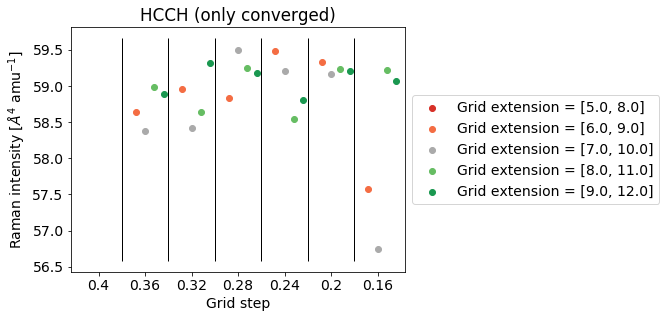

mean = 58.8579217 A^4.amu^-1; std. dev. = 6.09e-01 A^4.amu^-1; std. dev / mean = 1.035e-02
mean = 58.9582145 A^4.amu^-1; std. dev. = 7.07e-01 A^4.amu^-1; std. dev / mean = 1.200e-02


(58.95821452727273, 0.707465773455623)

In [18]:
name = "HCCH"
e_lim = (3409, 3414)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=e_lim, only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

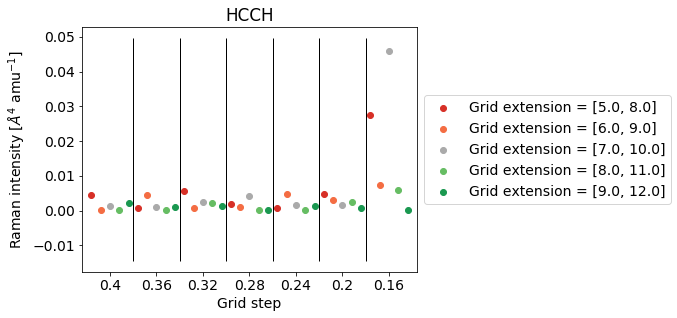

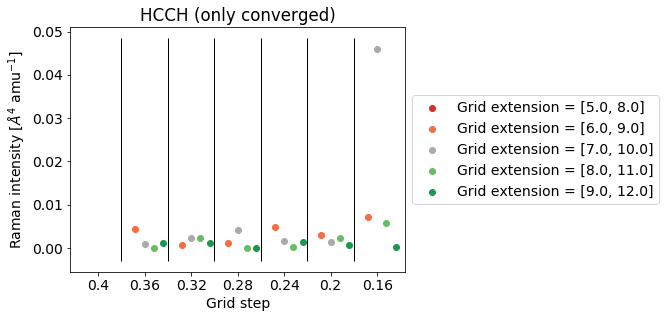

mean = 0.0038882 A^4.amu^-1; std. dev. = 8.98e-03 A^4.amu^-1; std. dev / mean = 2.310e+00
mean = 0.0044901 A^4.amu^-1; std. dev. = 7.49e-03 A^4.amu^-1; std. dev / mean = 1.669e+00


(0.004490124029045455, 0.007492094220740503)

In [19]:
name = "HCCH"
e_lim = (3295, 3325)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3307, 3322), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

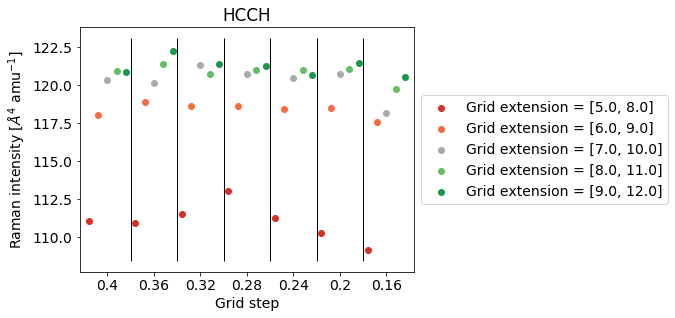

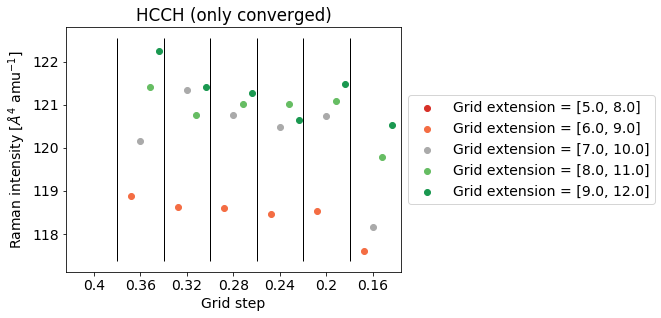

mean = 120.2120855 A^4.amu^-1; std. dev. = 1.26e+00 A^4.amu^-1; std. dev / mean = 1.051e-02
mean = 114.3290191 A^4.amu^-1; std. dev. = 4.48e+00 A^4.amu^-1; std. dev / mean = 3.920e-02


(114.32901909090907, 4.481254872772692)

In [20]:
name = "HCCH"
e_lim = (2006, 2013)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2007, 2012), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

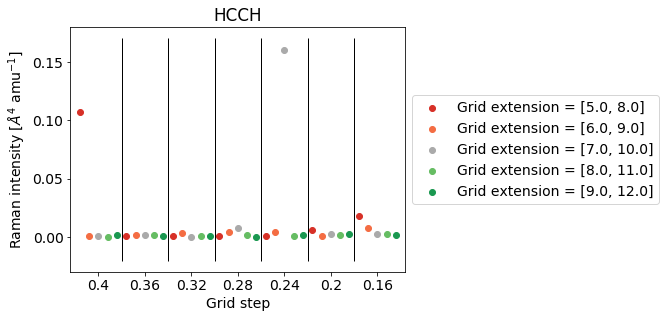

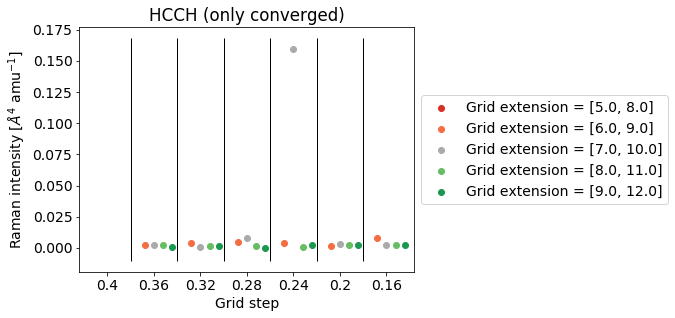

mean = 0.0091872 A^4.amu^-1; std. dev. = 3.15e-02 A^4.amu^-1; std. dev / mean = 3.426e+00
mean = 0.0128221 A^4.amu^-1; std. dev. = 3.04e-02 A^4.amu^-1; std. dev / mean = 2.368e+00


(0.012822113372799999, 0.03036245943320449)

In [21]:
name = "HCCH"
e_lim = (710, 770)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(715, 726), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

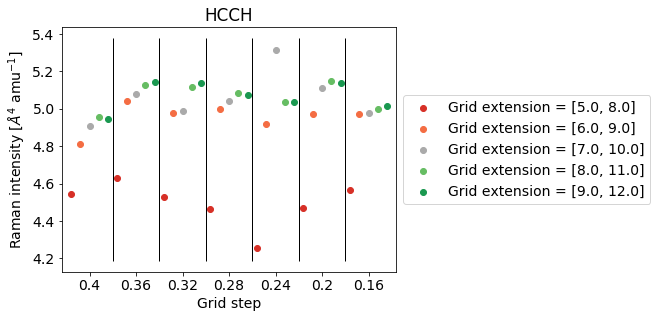

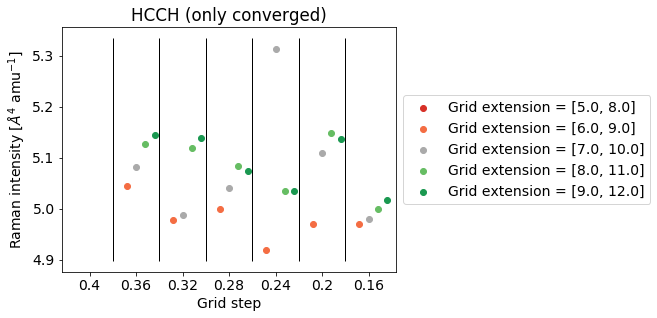

mean = 5.0604408 A^4.amu^-1; std. dev. = 8.35e-02 A^4.amu^-1; std. dev / mean = 1.649e-02
mean = 4.6436414 A^4.amu^-1; std. dev. = 2.19e-01 A^4.amu^-1; std. dev / mean = 4.725e-02


(4.643641429090909, 0.21939666928104554)

In [22]:
name = "HCCH"
e_lim = (627.5, 652.5)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(630, 637), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### HCN

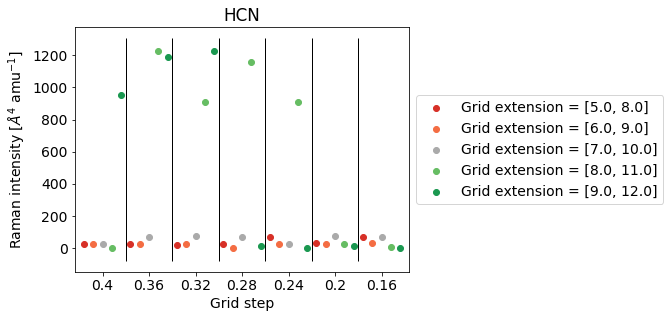

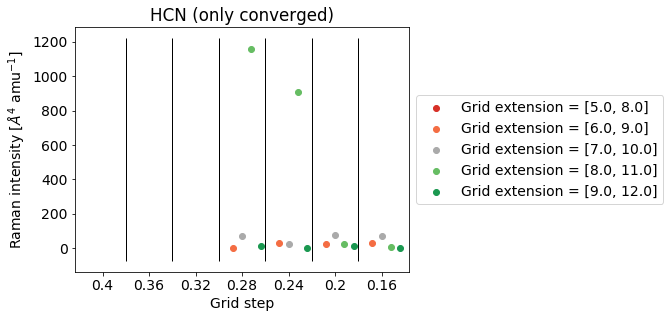

mean = 154.1723960 A^4.amu^-1; std. dev. = 3.36e+02 A^4.amu^-1; std. dev / mean = 2.182e+00
mean = 317.9353350 A^4.amu^-1; std. dev. = 4.74e+02 A^4.amu^-1; std. dev / mean = 1.490e+00


(317.9353350363158, 473.6383845913914)

In [23]:
name = "HCN"
e_lim = (3315, 3365)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3331, 3343), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

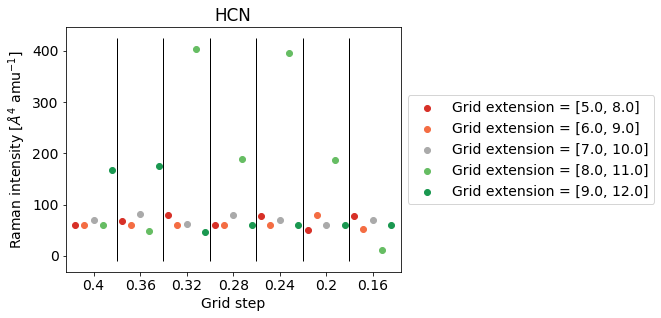

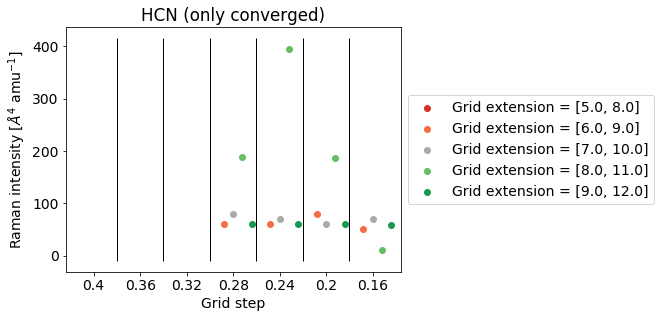

mean = 97.3142252 A^4.amu^-1; std. dev. = 8.88e+01 A^4.amu^-1; std. dev / mean = 9.128e-01
mean = 93.0522865 A^4.amu^-1; std. dev. = 8.10e+01 A^4.amu^-1; std. dev / mean = 8.704e-01


(93.05228653421052, 80.98874130655565)

In [24]:
name = "HCN"
e_lim = (2120, 2170)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2135, 2150), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

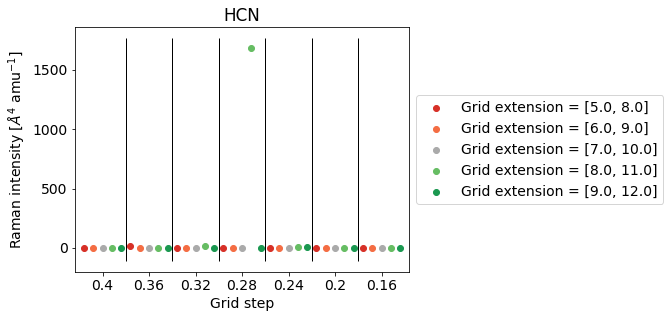

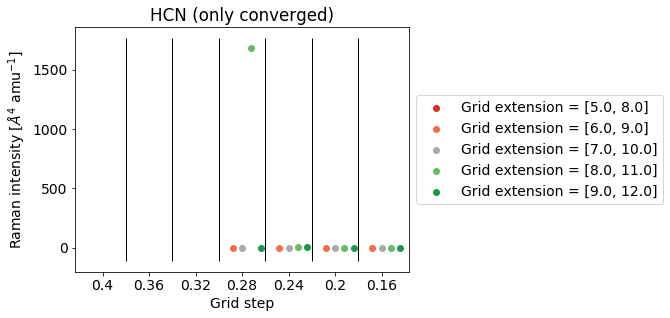

mean = 106.0467367 A^4.amu^-1; std. dev. = 4.06e+02 A^4.amu^-1; std. dev / mean = 3.831e+00
mean = 1.8669411 A^4.amu^-1; std. dev. = 4.31e+00 A^4.amu^-1; std. dev / mean = 2.310e+00


(1.866941126477043, 4.31257372848496)

In [25]:
name = "HCN"
e_lim = (700, 750)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(707, 718), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### NH3

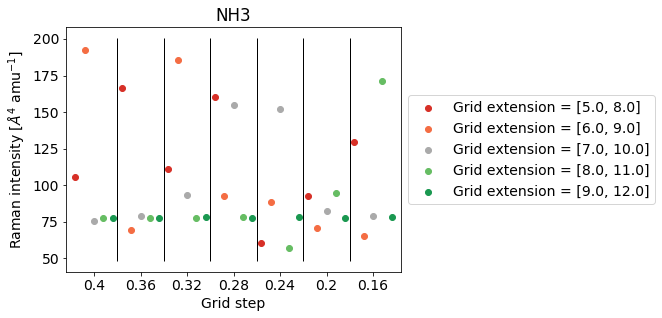

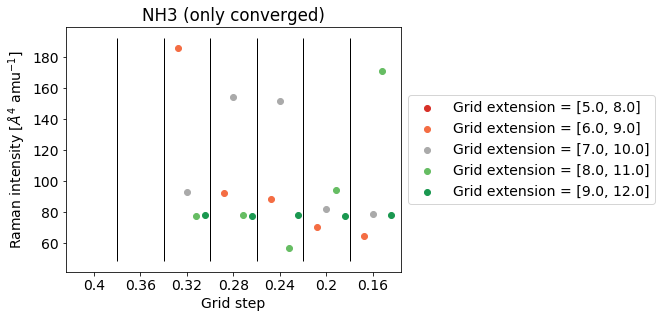

mean = 96.5718416 A^4.amu^-1; std. dev. = 3.62e+01 A^4.amu^-1; std. dev / mean = 3.751e-01
mean = 103.5025341 A^4.amu^-1; std. dev. = 3.91e+01 A^4.amu^-1; std. dev / mean = 3.782e-01


(103.50253414866668, 39.14454444254652)

In [26]:
name = "NH3"
e_lim = (3509, 3537)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3521, 3533), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

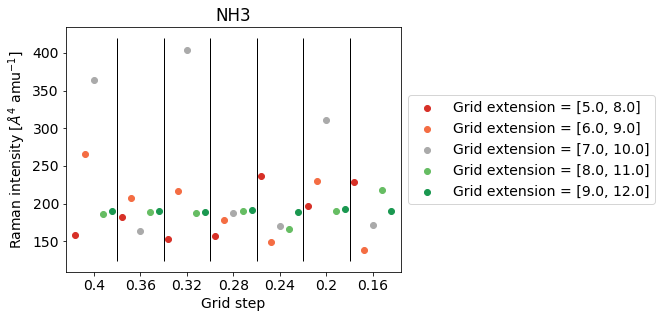

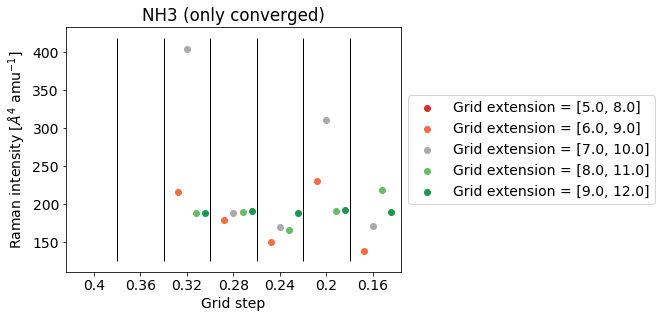

mean = 203.0962648 A^4.amu^-1; std. dev. = 5.74e+01 A^4.amu^-1; std. dev / mean = 2.824e-01
mean = 204.5829333 A^4.amu^-1; std. dev. = 5.23e+01 A^4.amu^-1; std. dev / mean = 2.556e-01


(204.58293330333336, 52.29370854986678)

In [27]:
name = "NH3"
e_lim = (3380, 3391)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3386.5, 3390), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

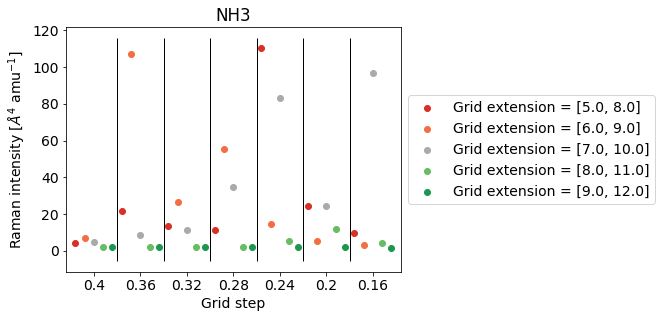

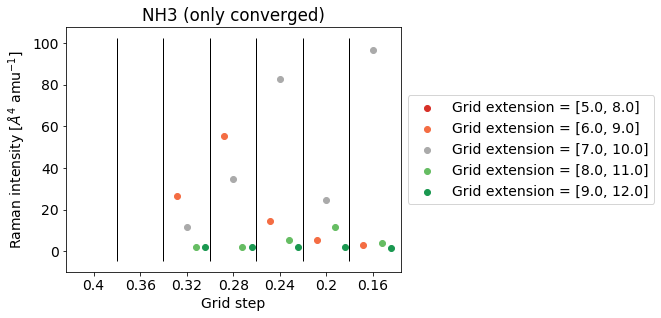

mean = 19.5033483 A^4.amu^-1; std. dev. = 2.72e+01 A^4.amu^-1; std. dev / mean = 1.396e+00
mean = 22.0141913 A^4.amu^-1; std. dev. = 3.46e+01 A^4.amu^-1; std. dev / mean = 1.571e+00


(22.014191299133334, 34.58931425718728)

In [28]:
name = "NH3"
e_lim = (1555, 1595)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1572, 1580), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

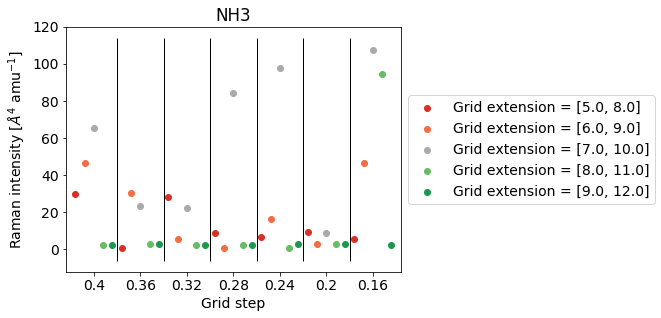

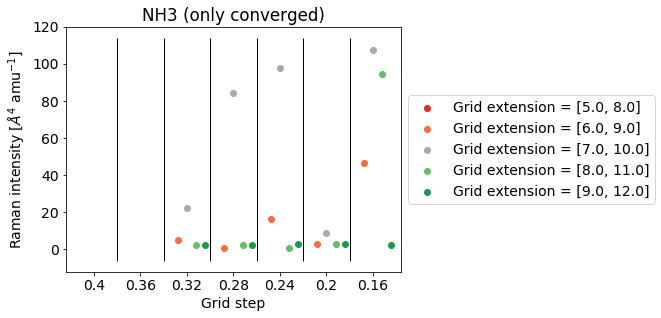

mean = 25.4853526 A^4.amu^-1; std. dev. = 3.70e+01 A^4.amu^-1; std. dev / mean = 1.452e+00
mean = 17.6428708 A^4.amu^-1; std. dev. = 1.86e+01 A^4.amu^-1; std. dev / mean = 1.053e+00


(17.642870836666663, 18.58654364496658)

In [29]:
name = "NH3"
e_lim = (790, 1020)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(850, 990), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### NF3

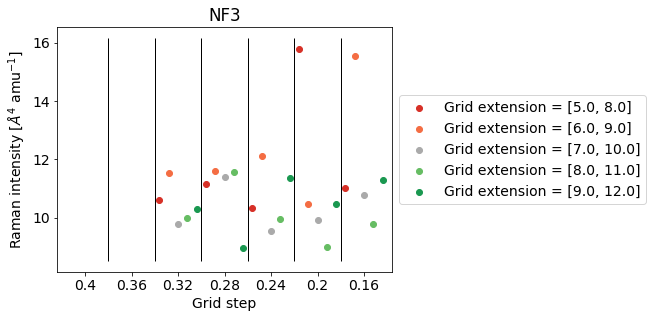

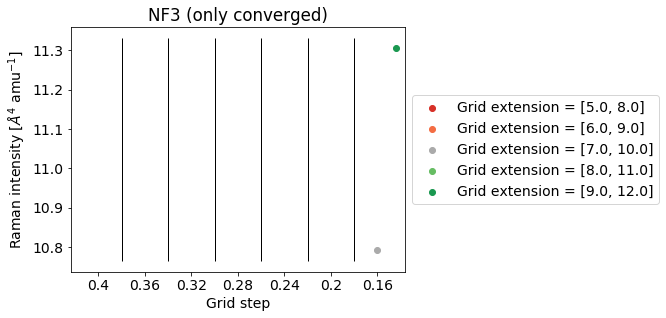

mean = 10.6255811 A^4.amu^-1; std. dev. = 6.34e-01 A^4.amu^-1; std. dev / mean = 5.966e-02
mean = 11.0237721 A^4.amu^-1; std. dev. = 1.69e+00 A^4.amu^-1; std. dev / mean = 1.533e-01


(11.023772055454545, 1.6903934214776946)

In [30]:
name = "NF3"
e_lim = (1020, 1045)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1031, 1037.5), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

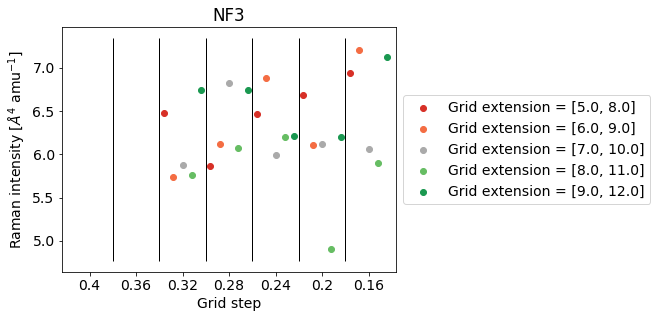

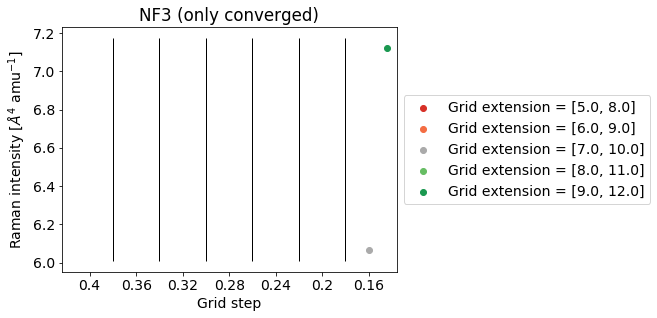

mean = 6.3621828 A^4.amu^-1; std. dev. = 5.40e-01 A^4.amu^-1; std. dev / mean = 8.489e-02
mean = 6.2792132 A^4.amu^-1; std. dev. = 5.06e-01 A^4.amu^-1; std. dev / mean = 8.062e-02


(6.279213175454545, 0.5062400187405162)

In [31]:
name = "NF3"
e_lim = (840, 900)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(864.5, 868), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

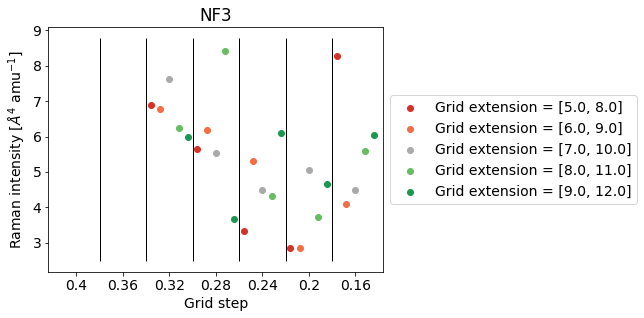

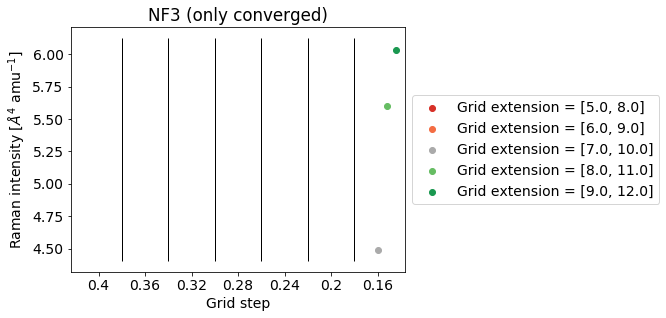

mean = 5.3715340 A^4.amu^-1; std. dev. = 6.50e-01 A^4.amu^-1; std. dev / mean = 1.210e-01
mean = 5.3650974 A^4.amu^-1; std. dev. = 1.59e+00 A^4.amu^-1; std. dev / mean = 2.969e-01


(5.365097383636364, 1.593163274213997)

In [32]:
name = "NF3"
e_lim = (625, 690)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(645, 648), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

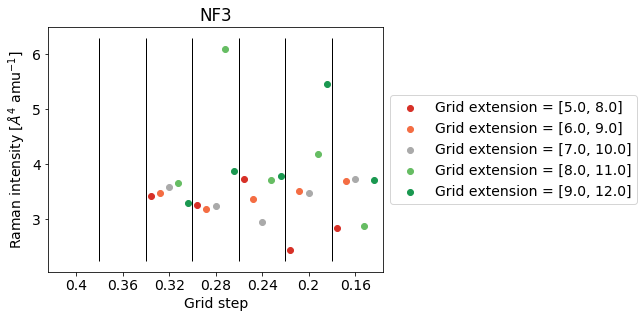

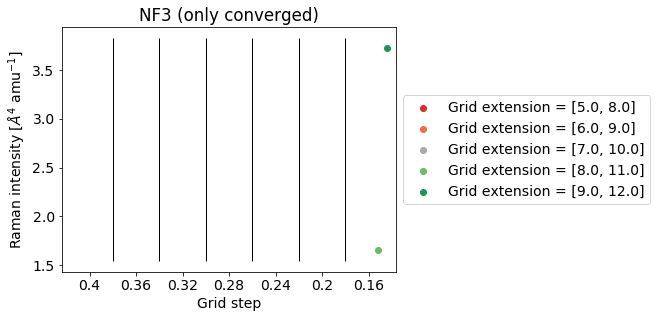

mean = 3.4442388 A^4.amu^-1; std. dev. = 3.97e-01 A^4.amu^-1; std. dev / mean = 1.151e-01
mean = 3.6519160 A^4.amu^-1; std. dev. = 7.70e-01 A^4.amu^-1; std. dev / mean = 2.108e-01


(3.6519159886363637, 0.7699602858899826)

In [33]:
name = "NF3"
e_lim = (440, 560)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(475, 484), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

### H3CCN

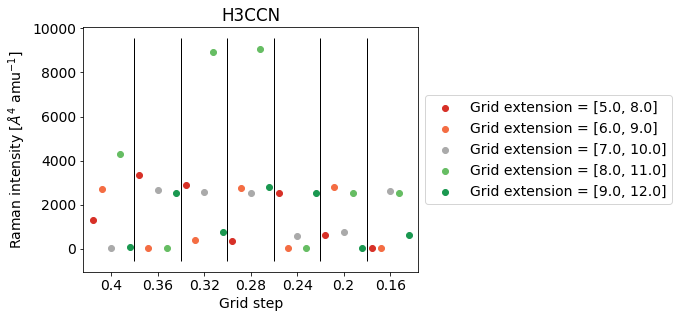

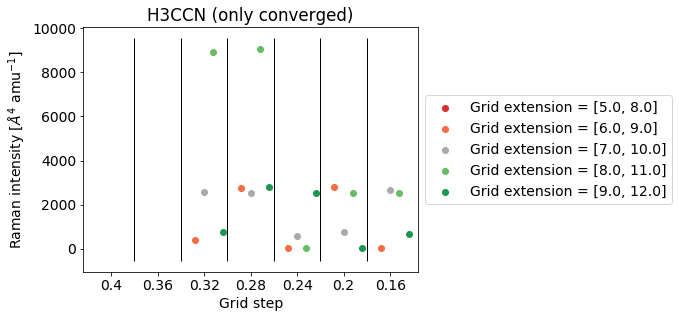

mean = 2248.3151981 A^4.amu^-1; std. dev. = 2.50e+03 A^4.amu^-1; std. dev / mean = 1.112e+00
mean = 1571.1126482 A^4.amu^-1; std. dev. = 1.43e+03 A^4.amu^-1; std. dev / mean = 9.110e-01


(1571.1126482133334, 1431.2991531579933)

In [34]:
name = "H3CCN"
e_lim = (3030, 3060)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3038, 3046), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

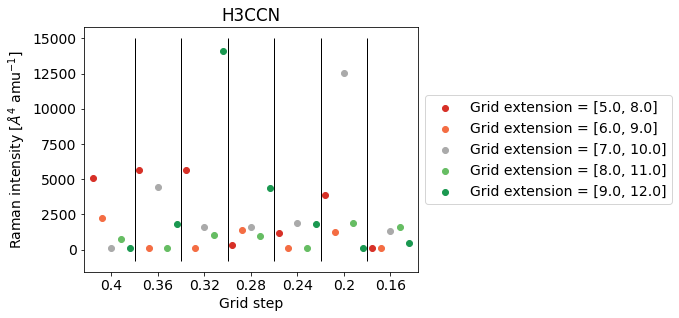

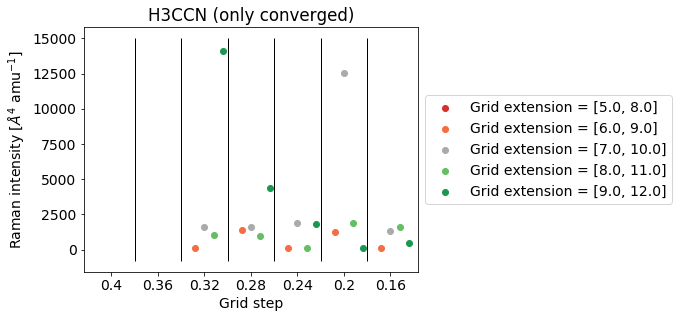

mean = 2422.2957221 A^4.amu^-1; std. dev. = 3.77e+03 A^4.amu^-1; std. dev / mean = 1.556e+00
mean = 2113.8812732 A^4.amu^-1; std. dev. = 2.12e+03 A^4.amu^-1; std. dev / mean = 1.005e+00


(2113.881273202, 2123.9312634038956)

In [35]:
name = "H3CCN"
e_lim = (2948, 2961)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2957.5, 2958.35), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

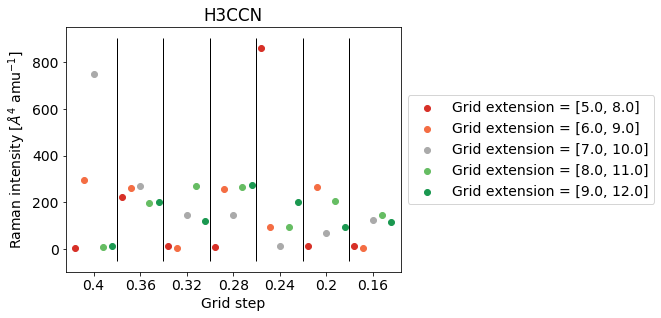

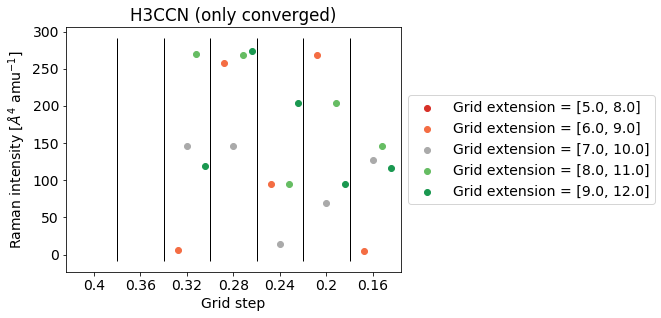

mean = 146.2661341 A^4.amu^-1; std. dev. = 8.75e+01 A^4.amu^-1; std. dev / mean = 5.984e-01
mean = 209.1752948 A^4.amu^-1; std. dev. = 2.59e+02 A^4.amu^-1; std. dev / mean = 1.238e+00


(209.17529482466665, 259.0130535627613)

In [36]:
name = "H3CCN"
e_lim = (2302, 2312)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2304.5, 2307), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

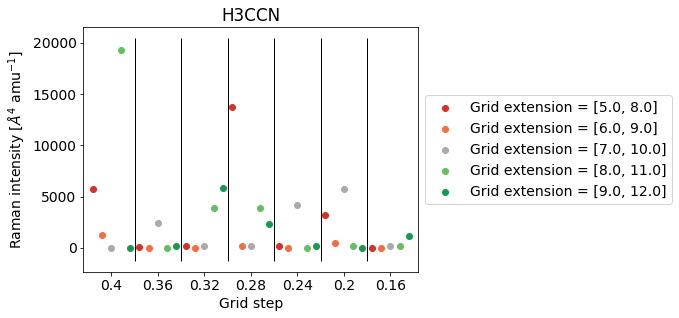

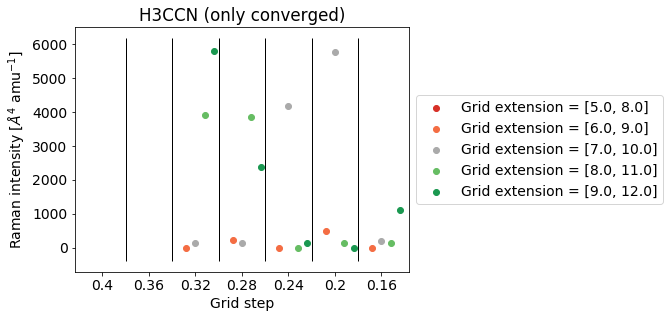

mean = 1435.9118829 A^4.amu^-1; std. dev. = 2.01e+03 A^4.amu^-1; std. dev / mean = 1.397e+00
mean = 3075.6860667 A^4.amu^-1; std. dev. = 5.59e+03 A^4.amu^-1; std. dev / mean = 1.816e+00


(3075.6860666899333, 5586.886290784392)

In [37]:
name = "H3CCN"
e_lim = (1360, 1435)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1386.5, 1391.5), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

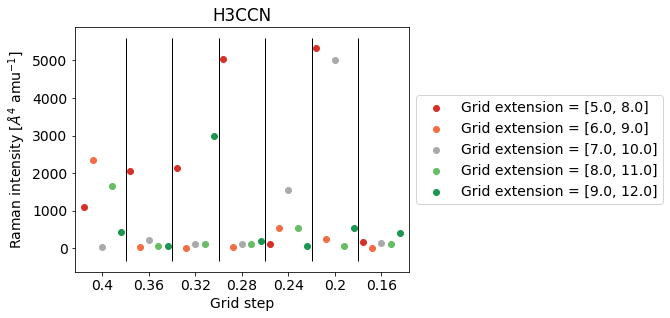

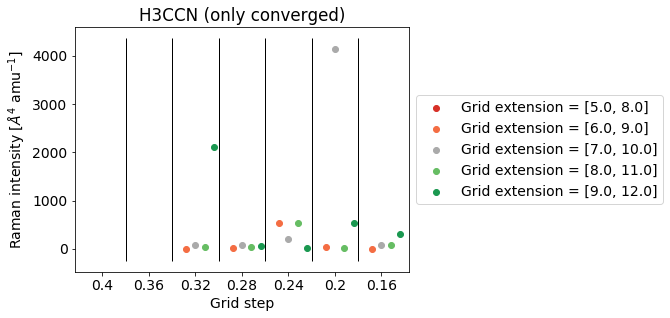

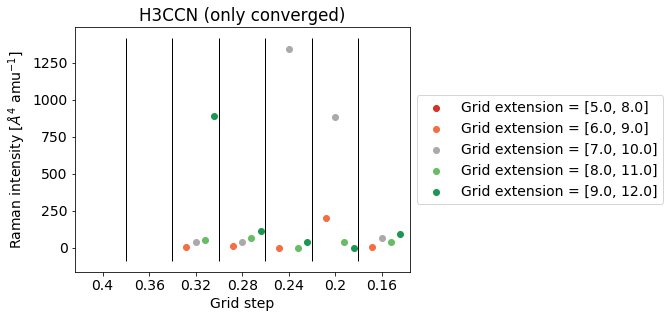

mean = 448.4498885 A^4.amu^-1; std. dev. = 9.66e+02 A^4.amu^-1; std. dev / mean = 2.153e+00
mean = 197.8209552 A^4.amu^-1; std. dev. = 3.66e+02 A^4.amu^-1; std. dev / mean = 1.849e+00


(197.820955208365, 365.82968040816564)

In [38]:
name = "H3CCN"
e_lim = (920, 1030)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(939, 963), only_converged=True)
plot_Raman_intensities(name, e_lim=(996, 1002.5), only_converged=True)
intensities_stats(name, (939, 963), only_converged=True)
intensities_stats(name, (996, 1002.5), only_converged=True)
# Cannot study the not-converged energies, as they are mixed

### H3CNC

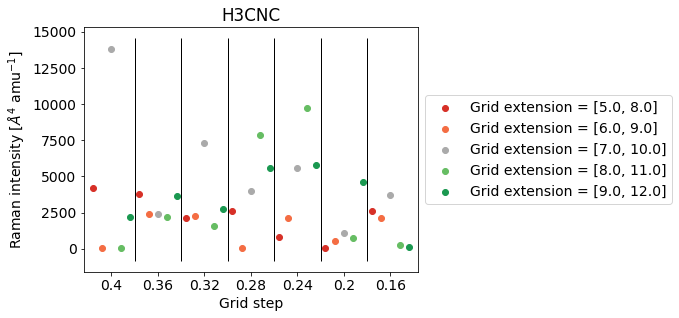

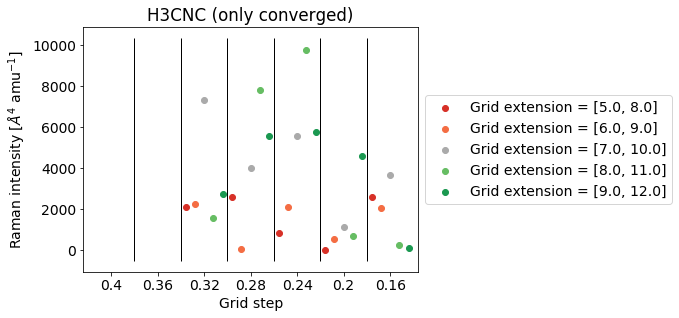

mean = 3040.4630535 A^4.amu^-1; std. dev. = 2.62e+03 A^4.amu^-1; std. dev / mean = 8.608e-01
mean = 3473.2995587 A^4.amu^-1; std. dev. = 3.69e+03 A^4.amu^-1; std. dev / mean = 1.062e+00


(3473.2995587100004, 3688.9183722613825)

In [39]:
name = "H3CNC"
e_lim = (3024, 3035)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(3030, 3034.5), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

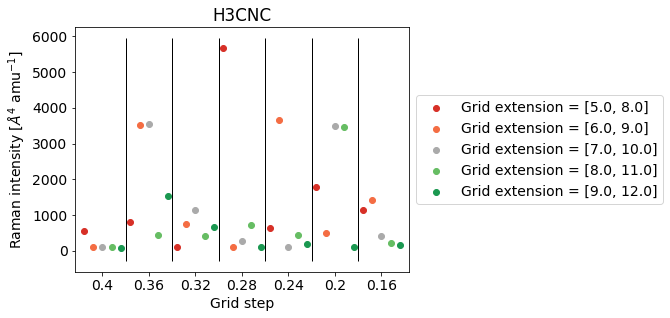

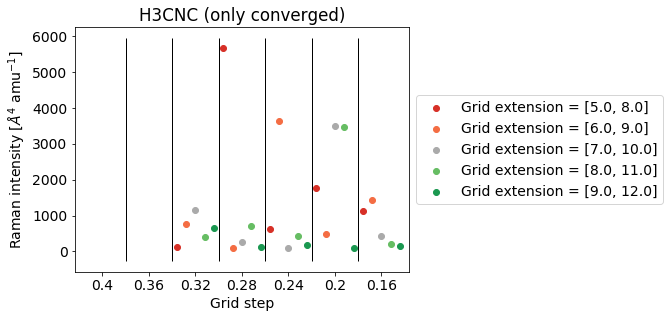

mean = 1107.1266618 A^4.amu^-1; std. dev. = 1.41e+03 A^4.amu^-1; std. dev / mean = 1.275e+00
mean = 1083.5469229 A^4.amu^-1; std. dev. = 1.29e+03 A^4.amu^-1; std. dev / mean = 1.194e+00


(1083.546922886, 1294.1419173756135)

In [40]:
name = "H3CNC"
e_lim = (2930, 2955)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(2950.3, 2951.3), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

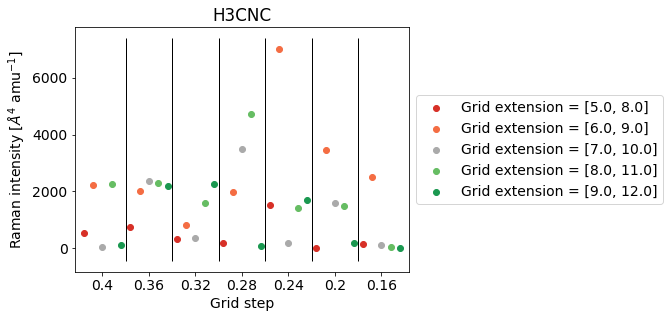

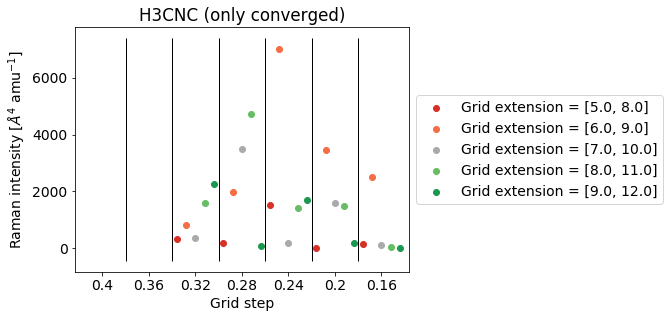

mean = 1484.4948225 A^4.amu^-1; std. dev. = 1.69e+03 A^4.amu^-1; std. dev / mean = 1.137e+00
mean = 1472.4127924 A^4.amu^-1; std. dev. = 9.37e+02 A^4.amu^-1; std. dev / mean = 6.363e-01


(1472.412792418, 936.9643548004854)

In [41]:
name = "H3CNC"
e_lim = (1395, 1415)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1405.5, 1409.5), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

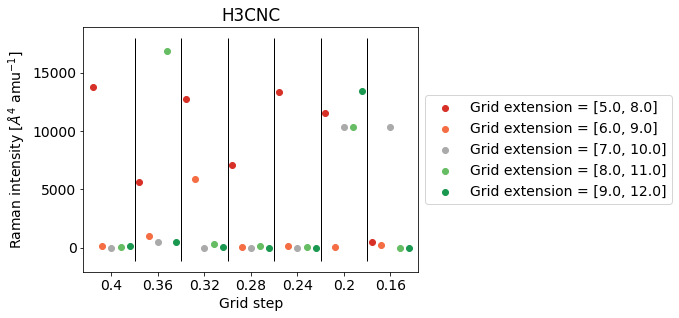

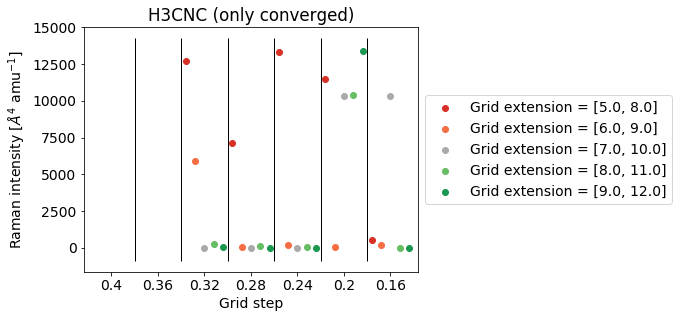

mean = 3868.6273955 A^4.amu^-1; std. dev. = 5.23e+03 A^4.amu^-1; std. dev / mean = 1.353e+00
mean = 3879.0325882 A^4.amu^-1; std. dev. = 5.99e+03 A^4.amu^-1; std. dev / mean = 1.544e+00


(3879.0325882395, 5989.592231807472)

In [42]:
name = "H3CNC"
e_lim = (1350, 1385)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1369, 1376), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

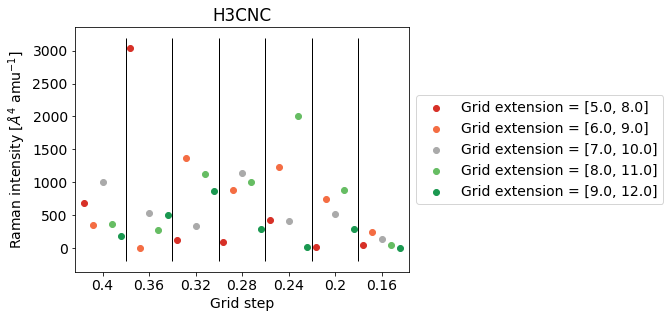

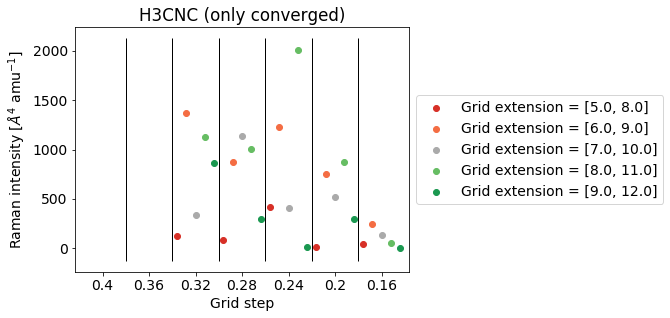

mean = 569.9841966 A^4.amu^-1; std. dev. = 5.19e+02 A^4.amu^-1; std. dev / mean = 9.103e-01
mean = 692.9341228 A^4.amu^-1; std. dev. = 8.24e+02 A^4.amu^-1; std. dev / mean = 1.189e+00


(692.934122817, 823.9285913676075)

In [43]:
name = "H3CNC"
e_lim = (1064, 1091)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(1083.5, 1088.5), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

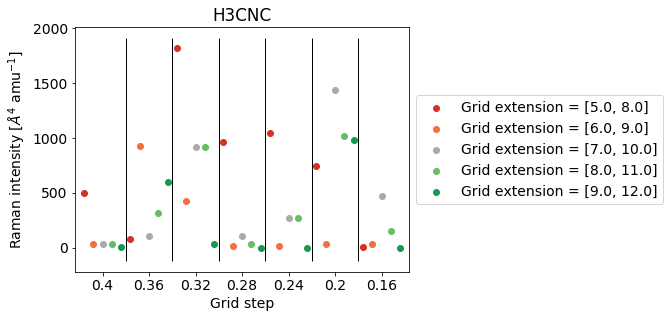

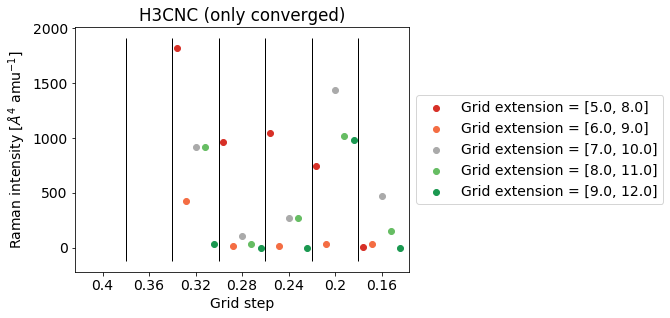

mean = 468.6803389 A^4.amu^-1; std. dev. = 5.18e+02 A^4.amu^-1; std. dev / mean = 1.106e+00
mean = 264.0572856 A^4.amu^-1; std. dev. = 2.98e+02 A^4.amu^-1; std. dev / mean = 1.129e+00


(264.05728562, 298.13887519260277)

In [44]:
name = "H3CNC"
e_lim = (970, 1000)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=(982, 988), only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

## N$_2$

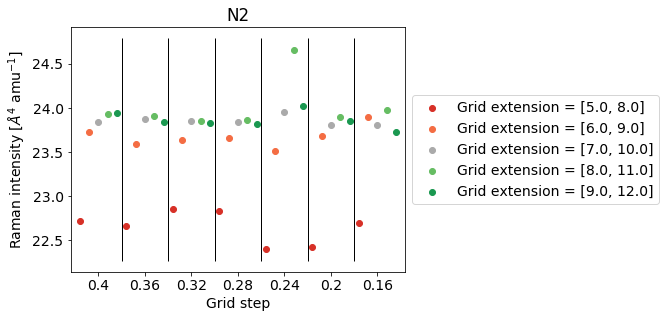

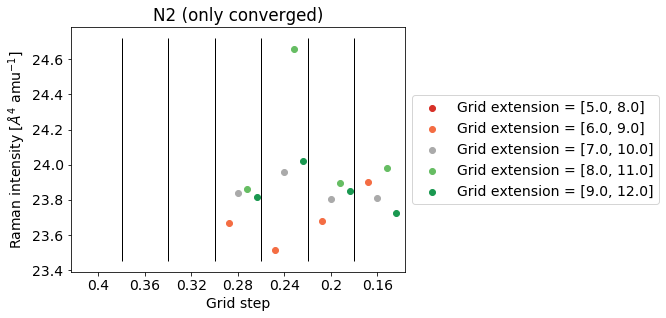

mean = 23.8732549 A^4.amu^-1; std. dev. = 2.37e-01 A^4.amu^-1; std. dev / mean = 9.931e-03
mean = 23.3918542 A^4.amu^-1; std. dev. = 5.76e-01 A^4.amu^-1; std. dev / mean = 2.464e-02


(23.391854221052633, 0.5763590305948738)

In [45]:
name = "N2"
e_lim = (2370, 2400)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=e_lim, only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

## CO

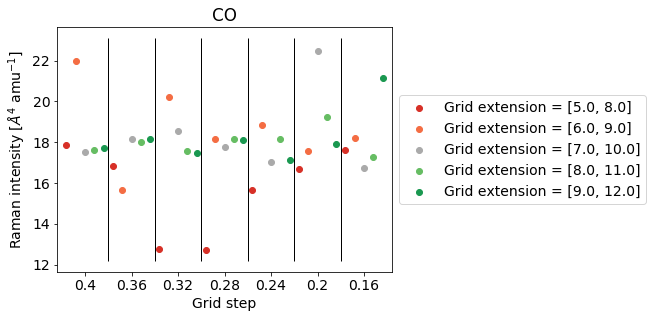

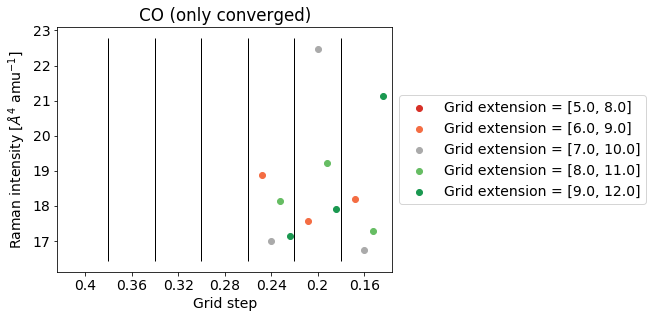

mean = 18.4786031 A^4.amu^-1; std. dev. = 1.67e+00 A^4.amu^-1; std. dev / mean = 9.019e-02
mean = 17.4319612 A^4.amu^-1; std. dev. = 1.92e+00 A^4.amu^-1; std. dev / mean = 1.099e-01


(17.431961182608696, 1.9154696573649606)

In [46]:
name = "CO"
e_lim = (2130, 2200)
plot_Raman_intensities(name, e_lim=e_lim)
plot_Raman_intensities(name, e_lim=e_lim, only_converged=True)
intensities_stats(name, e_lim, only_converged=True)
intensities_stats(name, e_lim, only_not_converged=True)

## Precision on the Raman intensity

The above cells show that statistics such as the mean value and the standard deviation of (almost) each Raman intensity can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged Raman intensities. Let us see how all these values can be used to assess the expected precision on the Raman intensities.

In order to do that, we need to gather the mean Raman intensity and the standard deviation for each intensity. This is done in the following cells, discriminating the data coming from converged and not converged calculations.

In [47]:
# Here are gathered all the values allowing to compute the mean
# value and the standard deviations with the intensities_stats function
e_lims = {
    "CH4": [(3075, 3100), (2930, 2975), (1470, 1525), (1248, 1290)],
    "SiF4": [(1000, 1070), (760, 860), (300, 400), (280, 300)],
    "H2O": [(3745, 3880), (3695, 3740), (1515, 1725)],
    "HCCH": [(3409, 3414), (3295, 3325), (2006, 2013), (710, 770),
             (627.5, 652.5)],
    "HCN": [(3315, 3365), (2120, 2170), (700, 750)],
    "NH3": [(3509, 3537), (3380, 3391), (1555, 1595), (790, 1020)],
    "NF3": [(1020, 1045), (840, 900), (625, 690), (440, 560)],
    "H3CCN": [(3030, 3060), (2948, 2961), (2302, 2312), (1360, 1435),
              (996, 1002.5), (939, 963)],
    "H3CNC": [(3024, 3035), (2930, 2955), (1395, 1415), (1350, 1385),
              (1064, 1091), (970, 1000)],
    "CO": [(2130, 2200)],
    "N2": [(2370, 2400)],
}

In [48]:
# Define which mean values and standard deviations of Raman intensities 
# cannot be computed for non-converged BigDFT input parameters (because
# two Raman intensities are too close for bad quality BigDFT, so that it
# becomes difficult to discriminate them).
exceptions = {
    "SiF4": [(280, 300), (300, 400)],
    "H3CCN": [(939, 963), (996, 1002.5)],
}
# The stats obtained along with the above plots are stored in the
# following dictionary, which has the molcule names as key. Stats for
# both converged and non-converged stats are computed, except for some
# cases defined above (where the non-converged results cannot be computed).
stats = {}
# Loop over the molecules
for name, lims in e_lims.items():
    stats[name] = {"converged": [], "not_converged": []}
    # Loop over the intensities
    for lim in lims:
        # Find the converged mean energy and standard deviation
        mean_c, std_dev_c = intensities_stats(
            name, lim, only_converged=True, verbosity=False
        )
        stats[name]["converged"].append({"mean": mean_c, "std_dev": std_dev_c})
        if not (name in exceptions and lim in exceptions[name]):
            # Find the non-converged mean energy and standard deviation
            mean_nc, std_dev_nc = intensities_stats(
                name, lim, only_not_converged=True, verbosity=False
            )
            stats[name]["not_converged"].append({"mean": mean_nc, "std_dev": std_dev_nc})
            # It is expected for the converged standard deviation to be larger
            # than the non-converged one; if this is not the case, print a message
            if std_dev_nc and std_dev_nc < std_dev_c:
                print(
                    f"The intensity between {lim[0]} and {lim[1]} cm^-1 of molecule {name} "
                    f"has a larger standard deviation for converged calculations "
                    f"({std_dev_c:.2f} > {std_dev_nc:.2f}). The mean "
                    f"converged value is {mean_c:.2e} A^4.amu^-1."
                )

The intensity between 3075 and 3100 cm^-1 of molecule CH4 has a larger standard deviation for converged calculations (3.05 > 1.07). The mean converged value is 1.47e+02 A^4.amu^-1.
The intensity between 2930 and 2975 cm^-1 of molecule CH4 has a larger standard deviation for converged calculations (7.75 > 5.10). The mean converged value is 2.29e+02 A^4.amu^-1.
The intensity between 1470 and 1525 cm^-1 of molecule CH4 has a larger standard deviation for converged calculations (0.51 > 0.15). The mean converged value is 4.31e+00 A^4.amu^-1.
The intensity between 1248 and 1290 cm^-1 of molecule CH4 has a larger standard deviation for converged calculations (0.10 > 0.06). The mean converged value is 1.81e-01 A^4.amu^-1.
The intensity between 760 and 860 cm^-1 of molecule SiF4 has a larger standard deviation for converged calculations (0.73 > 0.68). The mean converged value is 1.11e+01 A^4.amu^-1.
The intensity between 3295 and 3325 cm^-1 of molecule HCCH has a larger standard deviation for c

As seen above, the converged results have a larger dispersion than the con-converged one for half of the cases, whereas they are expected to have a lower dispersion in a majority of cases.

This actually shows how bad the quality of the Raman intensity found using BigDFT actually is. This is evidenced in the plots and stats given above:
- the standard deviation is ofter on the same order of magnitude as the mean value,
- the intensities may span several orders of magnitude, depending on the input parameters.

There clearly is something going wrong here, even though the values found for some molecules actually are close to what is reported in the literature.

In [49]:
def nb_under_3_std_dev(precision, only_converged=True,
                       only_not_converged=False):
    """
    Parameters
    ----------
    precision : float
        Precision on the Raman intensities (in cm^-1).
    
    Returns
    -------
    int
        The number of Raman intensities (supposed to be converged) in
        the test set for which three times the standard deviation is
        below the given precision.
    """
    # Set the key
    if only_converged:
        key = "converged"
    if only_not_converged:
        key = "not_converged"
    # Gather the standard deviations
    std_devs = [
        value["std_dev"]
        for values in stats.values()
        for value in values[key]
    ]
    # Return the number of Raman intensities with a standard deviation
    # below the specified precision
    return sum(3*std_dev <= precision for std_dev in std_devs)

We can study how the numbers of converged and non-converged data under a given precision evolves upon changing the precision value. This will allow us to evaluate the precision on the Raman intensities. This is done by finding the maximum difference between the converged and non-converged results for a given precision.

Precision: 1.96 A^4 amu^-1
Precision: 2.05 A^4 amu^-1


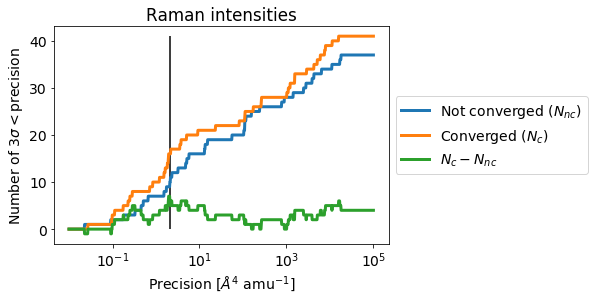

In [50]:
# Define a wide range of precisions
exponents = np.linspace(-2, 5, 1000)
precisions = [10**(n) for n in exponents]
# Get the number of converged and non-converged intensities below that
# precision
nb_c = [nb_under_3_std_dev(precision) for precision in precisions]
nb_nc = [
    nb_under_3_std_dev(precision, only_not_converged=True)
    for precision in precisions
]
# Compute the difference between both arrays
diff = np.array(nb_c) - np.array(nb_nc)
# Find the precision, associated with the largest difference
argmax = np.argmax(diff)
precision = precisions[argmax]
print(f"Precision: {precision:.2f} A^4 amu^-1")
argmax = np.argmax(diff[::-1])
precision = precisions[::-1][argmax]
print(f"Precision: {precision:.2f} A^4 amu^-1")
# Plot all the relevant data as a function of the precision
plt.plot(precisions, nb_nc, label=r"Not converged ($N_{nc}$)", lw=3)
plt.plot(precisions, nb_c, label=r"Converged ($N_{c}$)", lw=3)
plt.plot(precisions, diff, label=r"$N_c - N_{nc}$", lw=3)
plt.xscale('log')
plt.title("Raman intensities")
plt.xlabel(r"Precision [$\AA^4$ amu$^{-1}$]")
plt.ylabel(r"Number of $3 \sigma < $precision")
plt.vlines(precision, min(nb_nc), max(nb_c))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

It is actually not possible to see what the precision is for the Raman intensities. This is due to the fact that both converged and non-converged results have the same precision. 

We keep the section below, but this is mostly garbage, given the overall bad quality of the data.

## Plot the dispersion

Our main objective here is to give a broad overview on the evolution of the standard deviation between converged and not converged calculations.

This first plot has multiple goals:
- show that the standard deviation of not-converged parameters is way larger than for converged parameters
- show that three standard deviations is often below the precision found above for converged input parameters.
- show that three standard deviations is often above the precision found above for non-converged input parameters.
- show that there can be an offset of the mean values between converged and non-converged parameters.

All these can be shown by mostly comparing the converged and non-converged standard deviations of each Raman intensity. Another relevant quantity is the energy difference between the converged and non converged mean value of each intensity. One can therefore center all the converged mean phon energies on 0 and show how large three standard deviations are. The non converged standard deviations can be plotted in the same manner, but centered on the difference between the converged and non-converged mean energies. To help the viewer, vertical lines defines the +/- 15.93 cm$^{-1}$ precision limit for converged calculations.

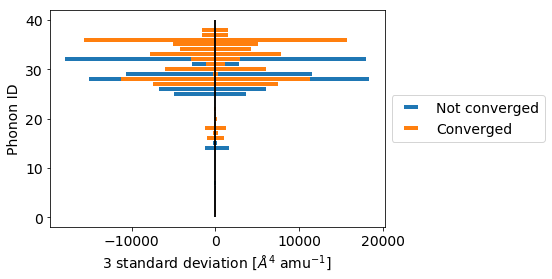

In [51]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    x_err = []  # Width of each error bar
    # Loop over the molecules
    for data in stats.values():
        # Loop over the intensities
        for i, value in enumerate(data[key]):
            # Define the width of the error-bar
            if not isinstance(value["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                converged_mean = data["converged"][i]["mean"]
                not_converged_mean = value["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Set the y-axis as an ID of the Raman intensity
    y = np.arange(len(x_err))
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("3 standard deviation [$\AA^4$ amu$^{-1}$]")
plt.ylabel("Phonon ID")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Same plot as the one above, but with a shorter range on the x-axis:

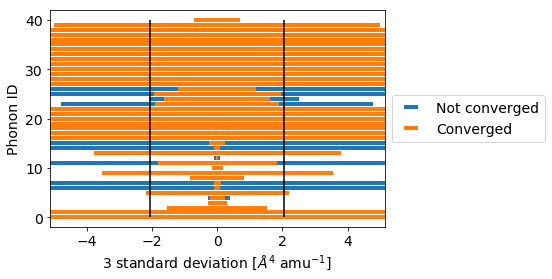

In [52]:
for key in ["not_converged", "converged"]:
    x_err = []
    x = []
    for name, data in stats.items():
        for i, value in enumerate(data[key]):
            if not isinstance(value["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value["std_dev"])
            if key == "not_converged":
                converged_mean = data["converged"][i]["mean"]
                not_converged_mean = value["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    if key == "converged":
        x = np.zeros_like(x_err)
    y = np.arange(len(x_err))
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
plt.xlabel("3 standard deviation [$\AA^4$ amu$^{-1}$]")
plt.ylabel("Phonon ID")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.xlim(-2.5*precision, 2.5*precision)
plt.show()

A similar plot as the one above can be produced, except that the y-axis gives the mean Raman intensity for the converged calculations. It seems that it mostly the low energy intensities that tend to increase the overall error.

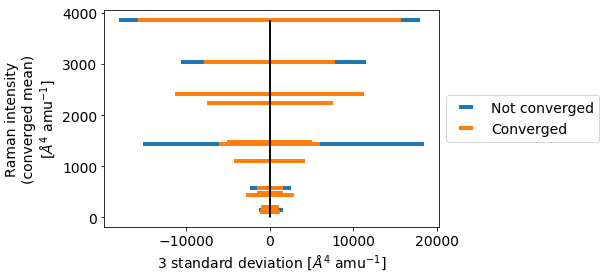

In [53]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean energy of the converged intensities
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for data in stats.values():
        # Loop over the intensities
        for i, value in enumerate(data[key]):
            # Define the location on the y-axis
            converged_mean = data["converged"][i]["mean"]
            y.append(converged_mean)
            # Define the width of the error-bar
            if not isinstance(value["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                not_converged_mean = value["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("3 standard deviation [$\AA^4$ amu$^{-1}$]")
plt.ylabel("Raman intensity\n(converged mean)\n[$\AA^4$ amu$^{-1}$]")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Same plot as the one above, but with a reduced range on the x-axis:

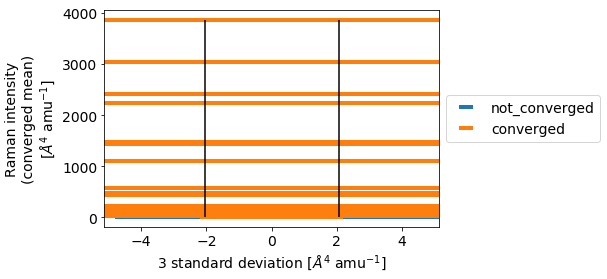

In [54]:
for key in ["not_converged", "converged"]:
    x_err = []
    x = []
    y = []
    for name, data in stats.items():
        for i, value in enumerate(data[key]):
            converged_mean = data["converged"][i]["mean"]
            y.append(converged_mean)
            if not isinstance(value["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value["std_dev"])
            if key == "not_converged":
                not_converged_mean = value["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    if key == "converged":
        x = np.zeros_like(x_err)
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=key)
plt.xlabel("3 standard deviation [$\AA^4$ amu$^{-1}$]")
plt.ylabel("Raman intensity\n(converged mean)\n[$\AA^4$ amu$^{-1}$]")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.xlim(-2.5*precision, 2.5*precision)
plt.show()

Similar plots can be done for each molecule:

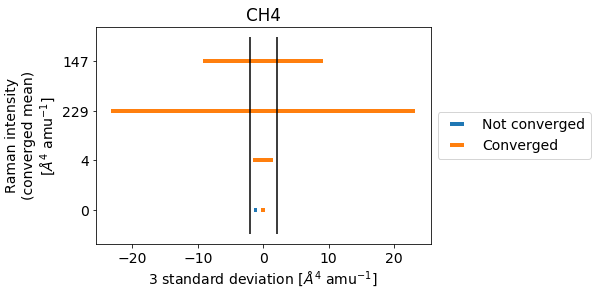

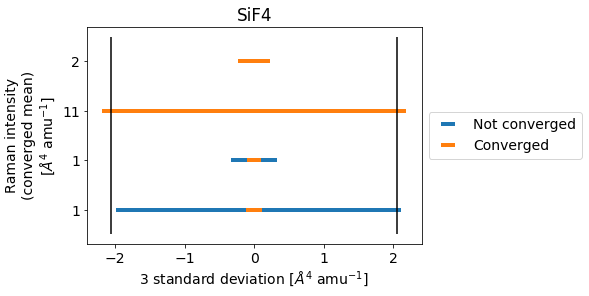

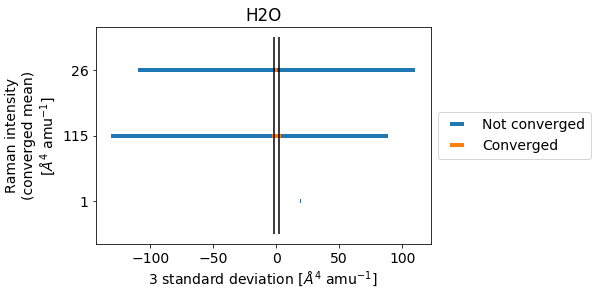

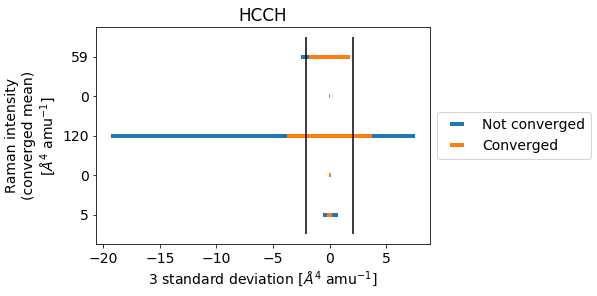

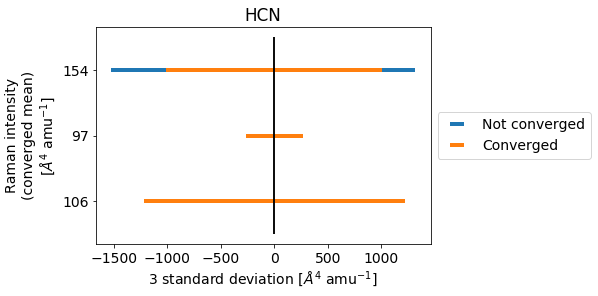

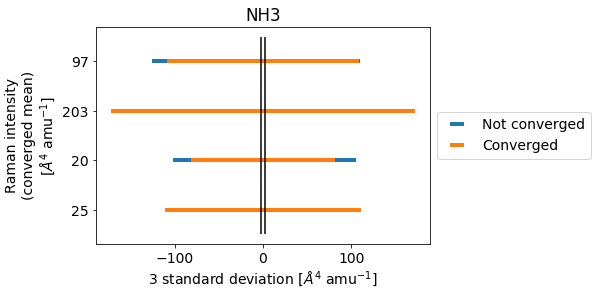

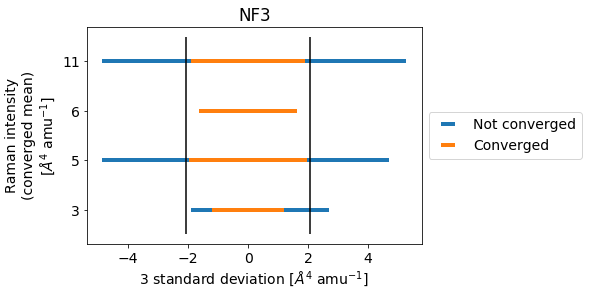

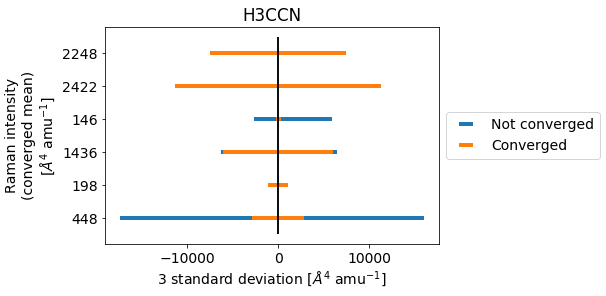

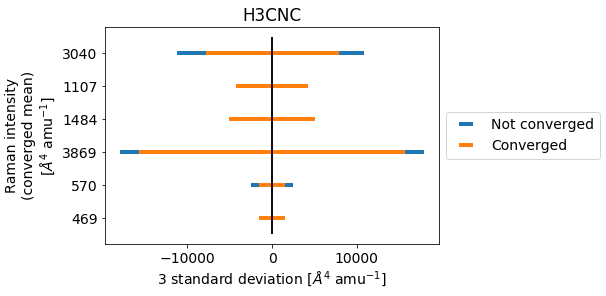

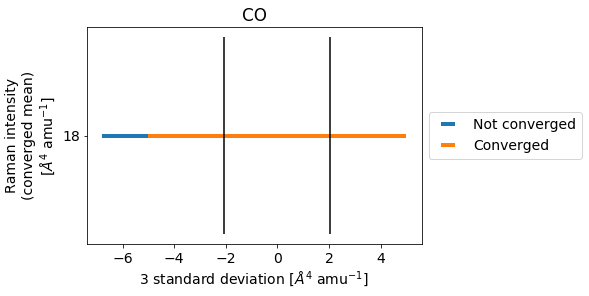

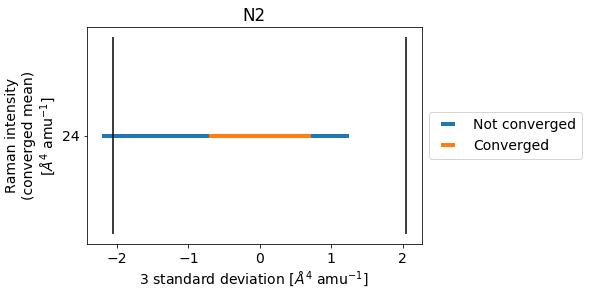

In [55]:
for name, data in stats.items():
    for key in ["not_converged", "converged"]:
        x_err = []
        x = []
        for i, value in enumerate(data[key]):
            if not isinstance(value["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value["std_dev"])
            if key == "not_converged":
                converged_mean = data["converged"][i]["mean"]
                not_converged_mean = value["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
        if key == "converged":
            x = np.zeros_like(x_err)
        y = np.arange(len(x_err))
        label = key.replace("_", " ").capitalize()
        plt.errorbar(x, y, xerr=x_err[::-1], linestyle="", elinewidth=4, label=label)
    plt.yticks(y, [f"{value['mean']:.0f}" for value in data["converged"][::-1]])
    plt.title(name)
    plt.xlabel("3 standard deviation [$\AA^4$ amu$^{-1}$]")
    plt.ylabel("Raman intensity\n(converged mean)\n[$\AA^4$ amu$^{-1}$]")
    plt.vlines([-precision, precision], min(y, default=0)-0.5, max(y, default=0)+0.5)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.show()